# MedROAR Demo Notebook
This notebook shows how to train MedROAR using MIMIC-IV after the data was formatted using the prepare_data.ipynb notebook. MedROAR is broadly applicable to many types of medical records. In the paper we discuss its use on both tabular and time-series datasets. This demo notebook shows how to apply it in the more complex case of mixed tabular and time series data. 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import gc
import sys
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from ROPE import RotaryEmbedding
from ROAR import scramble_order, MedROAR 
from utils import make_binary_plot
import os

/home/jovyan/medical/ROPE.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/jovyan/medical/ROPE.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


## Define a Function to Evaluate The Model During Training
Tests how loss changes when different numbers of bits are allowed in the embedding

In [3]:
def test_model(model, test, test_batches, criterion):
    torch.manual_seed(0)
    model.eval()
    if model.make_encodings:
        recording_indices = [0,1,2,4,8,16,32,64,128,256,512,1024,2048,4096]
    else:
        recording_indices = [0]
    losses = None
    pbar = tqdm(range(test_batches))
    test_iterator = iter(test)
    num_tests_done = 0
    for test_iter in pbar: 
        test_batch = next(test_iterator, None)
        if test_batch is not None:
            num_tests_done += 1
            loss_list = []
            x_test_tab, x_test_diag, x_test_seq = embed_sample(test_batch, device=device)
            decoder_input = scramble_order([x_test_tab, x_test_diag], x_test_seq, device=device, biased_scramble=True, simple_scramble=True, smoothing_ratio=0.0)
            x_test_type_reordered, x_test_value_reordered, seq_order = decoder_input
            
            for i in range(model.n_bits+1):
                if i in recording_indices:
                    with torch.amp.autocast("cuda"):
                        _, output = model(decoder_input, num_allowed_nodes = i)
                        loss = criterion(output, x_test_value_reordered)
                        loss_list.append(float(loss))

            if losses is None:
                losses = np.array(loss_list)
            else:
                losses += np.array(loss_list)
    
    losses /= num_tests_done
    #save normal samples
    mean_test_loss = np.mean(losses[0:])
    min_test_loss = np.min(losses)
    min_error_node = int(torch.FloatTensor(losses).argmin())
    model.best_complexity = min_error_node

    print("BEST ERROR OF "+str(round(min_test_loss,5))+" WITH", recording_indices[min_error_node], "NODES, USING", model.n_bits, "TOTAL NODES")
    print("Features:",0,"LOSS:", round(losses[0],5))
    if model.make_encodings:
        for node_index in range(1, len(losses)):
            difference = losses[node_index] - losses[node_index-1]
            pct_change = 1 - losses[node_index]/losses[node_index-1]
            print("Features:",recording_indices[node_index],"LOSS:", round(losses[node_index],5), "DIFF", round(difference,5),"or", round(pct_change*-100,2),"%")
            
    return min_test_loss

## Define a Helper Function to Prepare Data During Training
embed_sample is a helper function to prepare data pulled from a dataloader and get it into the right format for ROAR

In [4]:
def embed_sample(batch, device, reserved_tokens=2):
    #move samples to correct device
    tabular_data, types_diagnoses, values_diagnoses, types_seq, values_seq, positions_seq = batch
    tabular_data, types_diagnoses, values_diagnoses, types_seq, values_seq, positions_seq = tabular_data.to(device), types_diagnoses.to(device), values_diagnoses.to(device), types_seq.to(device), values_seq.to(device), positions_seq.to(device)

    #create type, position, value triplit for tabular demographic data. 
    #ROAR treats tokens with type 0, and 1 as special by default, these 2 tokes are reserved
    #Remember that NaN values were included in the data to mark missing data. This allows us to add the reserved tokens and THEN cast the NaNs to 0s
    tab_cols = tabular_data.shape[1]
    tab_type = torch.arange(tab_cols, device=device).repeat(tabular_data.shape[0],1) + reserved_tokens
    tab_value = torch.nan_to_num(tabular_data + reserved_tokens)
    tab_pos = torch.zeros(tab_type.shape[0], tab_type.shape[1])

    #create type, position, value triplit for diagnoses data
    diag_type = torch.nan_to_num(types_diagnoses + reserved_tokens)
    diag_value = torch.nan_to_num(values_diagnoses + reserved_tokens)
    diag_pos = torch.zeros(types_diagnoses.shape[0], types_diagnoses.shape[1])

    #create type, position, value triplit for time-series EHR data
    seq_type = torch.nan_to_num(types_seq + reserved_tokens)
    seq_value = torch.nan_to_num(values_seq + reserved_tokens)
    seq_pos = torch.nan_to_num(positions_seq)

    tab_data = (tab_type.long(), tab_value.long(), tab_pos.float())
    diag_data = (diag_type.long(), diag_value.long(), diag_pos.float())
    seq_data = (seq_type.long(), seq_value.long(), seq_pos.float())

    return tab_data, diag_data, seq_data

## Define The Training Function
Saves a copy of the model after each epoch

In [5]:
def train_model(train, test, model, epochs=10, aux_loss_weight=0.01, checkpoint_filename="model.pyt",
                lr=1e-4, label_smoothing=0, weight_decay=0.01, test_batches=10, epochs_between_test=10, running_average_window=1000):
    
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing, ignore_index=0)
    
    model.train()
    iters = len(train)
    best_mean_test_loss = np.inf
    best_min_test_loss = np.inf
    running_train_loss = []
    
    #training epochs
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scaler = torch.amp.GradScaler("cuda")
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epochs+1, steps_per_epoch=iters, div_factor=1e4, pct_start=0.01)
    for epoch in range(epochs+1):
        #set seed here, seed is set again at test. 
        #If not reset after test this leads to overfitting since noise is the same each epoch
        torch.manual_seed(np.random.randint(99999999))
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        print("--------------------------------------\nEPOCH", epoch)
        pbar = tqdm(train)
        for iteration, batch in enumerate(pbar):
            #prepare each sample using the helper function
            x_train_tab, x_train_diag, x_train_seq = embed_sample(batch, device=device)
            
            #scramble the order of the input data, we do this separately for the encoder and decoder input during training to avoid bias
            x_encoder_input = scramble_order([x_train_tab, x_train_diag], x_train_seq, device=device, biased_scramble=True, simple_scramble=False, smoothing_ratio=0.0)
            x_decoder_input = scramble_order([x_train_tab, x_train_diag], x_train_seq, device=device, biased_scramble=True, simple_scramble=False, smoothing_ratio=0.0)

            #pull out the ground truth values for training
            x_train_type_reordered, x_train_value_reordered, seq_order = x_decoder_input
            
            with torch.amp.autocast("cuda"):
                #run the model
                enc, output = model(x_decoder_input, encoder_input=x_encoder_input)
                loss = criterion(output, x_train_value_reordered)
                
                #aux loss forces the encodings to try to be useful
                if model.make_encodings:
                    if model.binary_encodings:
                        loss = loss + ((enc*2-1).mean(axis=0)**2).mean()*aux_loss_weight
                    else:
                        loss = loss + (enc**2).mean()*aux_loss_weight  

            #update the model
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

            #update the loss tracker
            running_train_loss.append(float(loss))
            running_train_loss = running_train_loss[-running_average_window:]

            #update the lr tracker
            current_lr = optimizer.param_groups[0]['lr']

            #update the progress bar
            pbar.set_description(f"Loss: {np.mean(running_train_loss):.4f} LR {current_lr:.8}")

        #test the model
        if epoch%epochs_between_test == 0:
            gc.collect()
            torch.cuda.empty_cache()
            model.eval()
            #evaluate model
            min_test_loss = test_model(model, test, test_batches, criterion)
            if min_test_loss < best_min_test_loss:
                model.cpu()
                #change this to just "model.state_dict()" if not using compiled model
                torch.save(model._orig_mod.state_dict(), checkpoint_filename)
                model = model.to(device)
                best_min_test_loss = min_test_loss
                   
        del output
        del loss
        
    model.eval()
    return model

## Load Prepared Data
Data prepared using the prepare_data.ipynb notebook

We will include diagnoses during training in this version, unlike the one shown in the paper

This data includes two datatypes which are considered "tabular" i.e. without position, and 1 sequential. 

Using this method for tabular data is an identical process, just excluding the sequence data

In [6]:
medical_data = np.load("medical_data.npz")

In [7]:
hadm_ids = medical_data["patient_ids"]

tabular_data = medical_data["patient_info"]
outcome_data = medical_data["patient_outcomes"]

#add the number of tabular data types to the diagnosis types so they are distinct
types_diagnoses = medical_data["itemtypes_diagnoses"] + tabular_data.shape[1] + 1
values_diagnoses = medical_data["values_diagnoses"]

#add the number of tabular data types + diagnosis type to the time series record types so they are distinct
types = medical_data["itemtypes"] + np.nanmax(types_diagnoses) + 1
values = medical_data["values"]
positions = medical_data["timestamps"]

## Divide into Train/Test

In [8]:
tab_train, tab_test, types_diagnoses_train, types_diagnoses_test, values_diagnoses_train, values_diagnoses_test, types_train, types_test, values_train, values_test, positions_train, positions_test, outcomes_train, outcomes_test, ids_train, ids_test = train_test_split(tabular_data, types_diagnoses, values_diagnoses, types, values, positions, outcome_data, hadm_ids, test_size=0.1, random_state=42)

## Training Parameters

In [9]:
train_batch_size=32
test_batch_size=32
num_workers=8

## Create Dataloaders

In [10]:
train = torch.utils.data.TensorDataset(torch.tensor(tab_train), torch.tensor(types_diagnoses_train), torch.tensor(values_diagnoses_train), torch.tensor(types_train), torch.tensor(values_train), torch.tensor(positions_train))
test = torch.utils.data.TensorDataset(torch.tensor(tab_test), torch.tensor(types_diagnoses_test), torch.tensor(values_diagnoses_test), torch.tensor(types_test), torch.tensor(values_test), torch.tensor(positions_test))

trainldr = torch.utils.data.DataLoader(train, batch_size=train_batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
testldr = torch.utils.data.DataLoader(test, batch_size=test_batch_size, shuffle=False, num_workers=num_workers)

## Create Model
* n_embedding = max dimensionality of the input (vocabulary size + 2)
* n_type_embedding = number of unique token types (also + 2)
* d_model = model dimension
* d_ff = feedforward dimension
* num_heads = num attention heads
* depth = number of transformer layers in the encoder and decoder, a depth of X will produce a model with an encoder with X layers and a decoder with X layers
* n_translation_layers = number of feedforward layers used to translate to/from the highly structured embedding
* n_bits = the number of dimensions (bits if binary_encodings=True) in the embedding
* binary_encodings = round embeddings to binary (T/F)
* ordered_embeddings = enforce hierarchy in embeddings (T/F)
* make_encodings = make embeddings (T/F). ROAR models can be used in decoder only contexts.
* learn_partial_encodings = learn to make embeddings which are invariant to missing information by masking part of encoder input during training (T/F)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#this is actually a fairly large model, reduce model dim, d_ff, and depth to decrease training complexity
model = MedROAR(n_embedding=64, n_type_embedding=1344, d_model=512, d_ff=2048, num_heads=8, depth=8, n_translation_layers=8, n_bits=16,
                            binary_encodings=True, ordered_encodings=True, 
                            make_encodings=True, learn_partial_encodings=True).to(device)

#compile with caution. 
#torch.compile can cause very strange bugs with this model architecture in some pytorch versions
model = torch.compile(model, fullgraph=True)

## Train Model

Use training helper function defined earlier in the notebook. Saves a copy of the model to disk after each epoch

In [12]:
#the ROAR training objective is very complex, 25 epochs is not enough to fully explore the data but it's good enough for a demo
model = train_model(trainldr, testldr, model=model, epochs=25, test_batches=50,
                    checkpoint_filename="model.pyt", epochs_between_test=1, lr=1e-4,
                    label_smoothing=0.01, weight_decay=0.01)

--------------------------------------
EPOCH 0


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.96525 WITH 1 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.96528
Features: 1 LOSS: 1.96525 DIFF -3e-05 or -0.0 %
Features: 2 LOSS: 1.96525 DIFF 0.0 or 0.0 %
Features: 4 LOSS: 1.96526 DIFF 0.0 or 0.0 %
Features: 8 LOSS: 1.96528 DIFF 2e-05 or 0.0 %
Features: 16 LOSS: 1.96527 DIFF -1e-05 or -0.0 %
--------------------------------------
EPOCH 1


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.74789 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.74797
Features: 1 LOSS: 1.74804 DIFF 7e-05 or 0.0 %
Features: 2 LOSS: 1.74803 DIFF -0.0 or -0.0 %
Features: 4 LOSS: 1.74807 DIFF 4e-05 or 0.0 %
Features: 8 LOSS: 1.74803 DIFF -4e-05 or -0.0 %
Features: 16 LOSS: 1.74789 DIFF -0.00014 or -0.01 %
--------------------------------------
EPOCH 2


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.64817 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.64885
Features: 1 LOSS: 1.64876 DIFF -0.0001 or -0.01 %
Features: 2 LOSS: 1.64868 DIFF -8e-05 or -0.0 %
Features: 4 LOSS: 1.64838 DIFF -0.0003 or -0.02 %
Features: 8 LOSS: 1.64836 DIFF -2e-05 or -0.0 %
Features: 16 LOSS: 1.64817 DIFF -0.00019 or -0.01 %
--------------------------------------
EPOCH 3


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.58252 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.58319
Features: 1 LOSS: 1.58285 DIFF -0.00035 or -0.02 %
Features: 2 LOSS: 1.58271 DIFF -0.00014 or -0.01 %
Features: 4 LOSS: 1.58258 DIFF -0.00013 or -0.01 %
Features: 8 LOSS: 1.58258 DIFF 0.0 or 0.0 %
Features: 16 LOSS: 1.58252 DIFF -6e-05 or -0.0 %
--------------------------------------
EPOCH 4


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.53257 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.53359
Features: 1 LOSS: 1.53312 DIFF -0.00046 or -0.03 %
Features: 2 LOSS: 1.53284 DIFF -0.00028 or -0.02 %
Features: 4 LOSS: 1.53276 DIFF -8e-05 or -0.0 %
Features: 8 LOSS: 1.53264 DIFF -0.00012 or -0.01 %
Features: 16 LOSS: 1.53257 DIFF -7e-05 or -0.0 %
--------------------------------------
EPOCH 5


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.50161 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.5028
Features: 1 LOSS: 1.5022 DIFF -0.00061 or -0.04 %
Features: 2 LOSS: 1.50203 DIFF -0.00016 or -0.01 %
Features: 4 LOSS: 1.50177 DIFF -0.00027 or -0.02 %
Features: 8 LOSS: 1.50174 DIFF -3e-05 or -0.0 %
Features: 16 LOSS: 1.50161 DIFF -0.00013 or -0.01 %
--------------------------------------
EPOCH 6


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.4813 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.48301
Features: 1 LOSS: 1.48239 DIFF -0.00061 or -0.04 %
Features: 2 LOSS: 1.48204 DIFF -0.00035 or -0.02 %
Features: 4 LOSS: 1.48158 DIFF -0.00046 or -0.03 %
Features: 8 LOSS: 1.48136 DIFF -0.00023 or -0.02 %
Features: 16 LOSS: 1.4813 DIFF -5e-05 or -0.0 %
--------------------------------------
EPOCH 7


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.46493 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.46695
Features: 1 LOSS: 1.46624 DIFF -0.00071 or -0.05 %
Features: 2 LOSS: 1.46594 DIFF -0.0003 or -0.02 %
Features: 4 LOSS: 1.46544 DIFF -0.00049 or -0.03 %
Features: 8 LOSS: 1.46501 DIFF -0.00043 or -0.03 %
Features: 16 LOSS: 1.46493 DIFF -9e-05 or -0.01 %
--------------------------------------
EPOCH 8


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.45373 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.45762
Features: 1 LOSS: 1.45663 DIFF -0.00099 or -0.07 %
Features: 2 LOSS: 1.45583 DIFF -0.0008 or -0.05 %
Features: 4 LOSS: 1.45483 DIFF -0.001 or -0.07 %
Features: 8 LOSS: 1.45422 DIFF -0.00061 or -0.04 %
Features: 16 LOSS: 1.45373 DIFF -0.00049 or -0.03 %
--------------------------------------
EPOCH 9


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.43919 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.44198
Features: 1 LOSS: 1.44132 DIFF -0.00066 or -0.05 %
Features: 2 LOSS: 1.441 DIFF -0.00032 or -0.02 %
Features: 4 LOSS: 1.44023 DIFF -0.00077 or -0.05 %
Features: 8 LOSS: 1.43948 DIFF -0.00075 or -0.05 %
Features: 16 LOSS: 1.43919 DIFF -0.00029 or -0.02 %
--------------------------------------
EPOCH 10


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.4283 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.43201
Features: 1 LOSS: 1.43127 DIFF -0.00074 or -0.05 %
Features: 2 LOSS: 1.43064 DIFF -0.00063 or -0.04 %
Features: 4 LOSS: 1.42936 DIFF -0.00128 or -0.09 %
Features: 8 LOSS: 1.42845 DIFF -0.00091 or -0.06 %
Features: 16 LOSS: 1.4283 DIFF -0.00014 or -0.01 %
--------------------------------------
EPOCH 11


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.41722 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.41988
Features: 1 LOSS: 1.41931 DIFF -0.00057 or -0.04 %
Features: 2 LOSS: 1.41884 DIFF -0.00046 or -0.03 %
Features: 4 LOSS: 1.41824 DIFF -0.00061 or -0.04 %
Features: 8 LOSS: 1.41739 DIFF -0.00084 or -0.06 %
Features: 16 LOSS: 1.41722 DIFF -0.00017 or -0.01 %
--------------------------------------
EPOCH 12


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.41065 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.41337
Features: 1 LOSS: 1.41281 DIFF -0.00056 or -0.04 %
Features: 2 LOSS: 1.41239 DIFF -0.00042 or -0.03 %
Features: 4 LOSS: 1.41188 DIFF -0.00051 or -0.04 %
Features: 8 LOSS: 1.41091 DIFF -0.00097 or -0.07 %
Features: 16 LOSS: 1.41065 DIFF -0.00026 or -0.02 %
--------------------------------------
EPOCH 13


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.40834 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.41197
Features: 1 LOSS: 1.41123 DIFF -0.00074 or -0.05 %
Features: 2 LOSS: 1.41088 DIFF -0.00035 or -0.03 %
Features: 4 LOSS: 1.40953 DIFF -0.00135 or -0.1 %
Features: 8 LOSS: 1.40861 DIFF -0.00092 or -0.07 %
Features: 16 LOSS: 1.40834 DIFF -0.00027 or -0.02 %
--------------------------------------
EPOCH 14


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.40224 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.40499
Features: 1 LOSS: 1.40451 DIFF -0.00047 or -0.03 %
Features: 2 LOSS: 1.40414 DIFF -0.00037 or -0.03 %
Features: 4 LOSS: 1.40349 DIFF -0.00065 or -0.05 %
Features: 8 LOSS: 1.40265 DIFF -0.00084 or -0.06 %
Features: 16 LOSS: 1.40224 DIFF -0.00041 or -0.03 %
--------------------------------------
EPOCH 15


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.3943 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.3969
Features: 1 LOSS: 1.39642 DIFF -0.00048 or -0.03 %
Features: 2 LOSS: 1.39598 DIFF -0.00044 or -0.03 %
Features: 4 LOSS: 1.39534 DIFF -0.00064 or -0.05 %
Features: 8 LOSS: 1.39454 DIFF -0.0008 or -0.06 %
Features: 16 LOSS: 1.3943 DIFF -0.00024 or -0.02 %
--------------------------------------
EPOCH 16


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.39153 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.39411
Features: 1 LOSS: 1.39358 DIFF -0.00053 or -0.04 %
Features: 2 LOSS: 1.39321 DIFF -0.00037 or -0.03 %
Features: 4 LOSS: 1.39266 DIFF -0.00055 or -0.04 %
Features: 8 LOSS: 1.39182 DIFF -0.00085 or -0.06 %
Features: 16 LOSS: 1.39153 DIFF -0.00029 or -0.02 %
--------------------------------------
EPOCH 17


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.38932 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.39237
Features: 1 LOSS: 1.39194 DIFF -0.00043 or -0.03 %
Features: 2 LOSS: 1.39154 DIFF -0.0004 or -0.03 %
Features: 4 LOSS: 1.39092 DIFF -0.00062 or -0.04 %
Features: 8 LOSS: 1.3898 DIFF -0.00113 or -0.08 %
Features: 16 LOSS: 1.38932 DIFF -0.00047 or -0.03 %
--------------------------------------
EPOCH 18


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.38654 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.38959
Features: 1 LOSS: 1.38914 DIFF -0.00045 or -0.03 %
Features: 2 LOSS: 1.3888 DIFF -0.00035 or -0.02 %
Features: 4 LOSS: 1.38807 DIFF -0.00073 or -0.05 %
Features: 8 LOSS: 1.38694 DIFF -0.00113 or -0.08 %
Features: 16 LOSS: 1.38654 DIFF -0.0004 or -0.03 %
--------------------------------------
EPOCH 19


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.38528 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.38819
Features: 1 LOSS: 1.38765 DIFF -0.00054 or -0.04 %
Features: 2 LOSS: 1.38721 DIFF -0.00045 or -0.03 %
Features: 4 LOSS: 1.38655 DIFF -0.00066 or -0.05 %
Features: 8 LOSS: 1.38563 DIFF -0.00092 or -0.07 %
Features: 16 LOSS: 1.38528 DIFF -0.00036 or -0.03 %
--------------------------------------
EPOCH 20


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.38385 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.38696
Features: 1 LOSS: 1.38659 DIFF -0.00037 or -0.03 %
Features: 2 LOSS: 1.38622 DIFF -0.00037 or -0.03 %
Features: 4 LOSS: 1.38542 DIFF -0.0008 or -0.06 %
Features: 8 LOSS: 1.3843 DIFF -0.00112 or -0.08 %
Features: 16 LOSS: 1.38385 DIFF -0.00045 or -0.03 %
--------------------------------------
EPOCH 21


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.38065 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.38387
Features: 1 LOSS: 1.38342 DIFF -0.00044 or -0.03 %
Features: 2 LOSS: 1.38307 DIFF -0.00036 or -0.03 %
Features: 4 LOSS: 1.38227 DIFF -0.0008 or -0.06 %
Features: 8 LOSS: 1.38111 DIFF -0.00116 or -0.08 %
Features: 16 LOSS: 1.38065 DIFF -0.00046 or -0.03 %
--------------------------------------
EPOCH 22


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.38033 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.38343
Features: 1 LOSS: 1.38298 DIFF -0.00045 or -0.03 %
Features: 2 LOSS: 1.38261 DIFF -0.00037 or -0.03 %
Features: 4 LOSS: 1.38178 DIFF -0.00084 or -0.06 %
Features: 8 LOSS: 1.38078 DIFF -0.001 or -0.07 %
Features: 16 LOSS: 1.38033 DIFF -0.00045 or -0.03 %
--------------------------------------
EPOCH 23


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.38059 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.38371
Features: 1 LOSS: 1.38331 DIFF -0.00041 or -0.03 %
Features: 2 LOSS: 1.38292 DIFF -0.00039 or -0.03 %
Features: 4 LOSS: 1.3821 DIFF -0.00082 or -0.06 %
Features: 8 LOSS: 1.3811 DIFF -0.001 or -0.07 %
Features: 16 LOSS: 1.38059 DIFF -0.00051 or -0.04 %
--------------------------------------
EPOCH 24


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.38061 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.38368
Features: 1 LOSS: 1.38324 DIFF -0.00044 or -0.03 %
Features: 2 LOSS: 1.3829 DIFF -0.00035 or -0.02 %
Features: 4 LOSS: 1.38206 DIFF -0.00084 or -0.06 %
Features: 8 LOSS: 1.3811 DIFF -0.00096 or -0.07 %
Features: 16 LOSS: 1.38061 DIFF -0.00049 or -0.04 %
--------------------------------------
EPOCH 25


  0%|          | 0/1419 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

BEST ERROR OF 1.38016 WITH 16 NODES, USING 16 TOTAL NODES
Features: 0 LOSS: 1.38325
Features: 1 LOSS: 1.38282 DIFF -0.00044 or -0.03 %
Features: 2 LOSS: 1.38242 DIFF -0.0004 or -0.03 %
Features: 4 LOSS: 1.38163 DIFF -0.00079 or -0.06 %
Features: 8 LOSS: 1.38066 DIFF -0.00098 or -0.07 %
Features: 16 LOSS: 1.38016 DIFF -0.0005 or -0.04 %


################################################################################################################################
# Plotting Clusters
################################################################################################################################

## Load The Trained Model From The Saved Checkpoint
Requires whatever initial parameters were used to create the trained model

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MedROAR(n_embedding=64, n_type_embedding=1344, d_model=512, d_ff=2048, num_heads=8, depth=8, n_translation_layers=8, n_bits=16,
                            binary_encodings=True, ordered_encodings=True, 
                            make_encodings=True, learn_partial_encodings=True).to(device)

model.load_state_dict(torch.load("model.pyt"))

/tmp/ipykernel_371338/853156252.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pyt"))


<All keys matched successfully>

## Use Demographics Plus The First X Hours of Time-Series Data To Make Clusters
Do not include diagnoses.

In [15]:
#remember that position 2048 in the prepared data corresponds to 14 days of time 
one_hour = 2048/(24*14)

################################################
#Change this to change the number of hours used
################################################
max_hours = 8
############################

#get information only from patients who have information later than max_hours (i.e. were not discharged or died earlier than that)
key2 = np.nan_to_num(positions).max(axis=1) > (one_hour*max_hours)

tab_test_temp = tabular_data[key2].copy()

#zero out all diagnoses, we will not use them here
types_diagnoses_temp = types_diagnoses[key2].copy() 
values_diagnoses_temp = values_diagnoses[key2].copy()
types_diagnoses_temp[:] = np.nan
values_diagnoses_temp[:] = np.nan

types_test_temp = types[key2].copy()
values_test_temp = values[key2].copy()
positions_test_temp = positions[key2].copy()
outcomes_test_temp = outcome_data[key2].copy()
ids_test_temp = hadm_ids[key2].copy()

key = np.nan_to_num(positions_test_temp) > (one_hour*max_hours)

#zero out all positions after max_hours
types_test_temp[key] = np.nan
values_test_temp[key] = np.nan
positions_test_temp[key] = np.nan

## Define Helper Functions To Encode The Data

In [16]:
def embed_data(model, dlr, batches=5000):
    embeddings = []
    labels = []
    ids = []
    torch.manual_seed(0)
    model.eval()
    with torch.no_grad(): 
        pbar = tqdm(range(batches))
        iterator = iter(dlr)
        num_tests_done = 0
        for test_iter in pbar: 
            batch = next(iterator, None)
            if batch is not None:
                x_tab_test, x_diagnoses_types_test, x_diagnoses_values_test, x_seq_types_test, x_seq_values_test, x_seq_positions_test, y_test, hadm_id = batch
                x_test_tab, x_test_diag, x_test_seq = embed_sample((x_tab_test, x_diagnoses_types_test, x_diagnoses_values_test, x_seq_types_test, x_seq_values_test, x_seq_positions_test), device=device)
                
                x_test_type_reordered, x_test_value_reordered, seq_order = scramble_order([x_test_tab, x_test_diag], x_test_seq, device=device)
                
                with torch.amp.autocast("cuda"):
                    enc, output = model((x_test_type_reordered, x_test_value_reordered, seq_order))
                    embeddings.append(enc.cpu().numpy())
                    labels.append(y_test.cpu().numpy())
                    ids.append(hadm_id.cpu().numpy())
    return np.concatenate(embeddings), np.concatenate(labels), np.concatenate(ids)

def encode_dataset(X, y, ids):
    tab_test, types_diagnoses_test, values_diagnoses_test, types_test, values_test, positions_test = X

    embedding_dts = torch.utils.data.TensorDataset(torch.tensor(tab_test), torch.tensor(types_diagnoses_test), torch.tensor(values_diagnoses_test), torch.tensor(types_test), torch.tensor(values_test), torch.tensor(positions_test), torch.tensor(y), torch.tensor(ids))
    embedding_dlr = torch.utils.data.DataLoader(embedding_dts, batch_size=64)
    x_emb, y_emb, ids_emb = embed_data(model, embedding_dlr)
    X = pd.DataFrame(x_emb)
    y = pd.DataFrame(y_emb)
    ids = pd.DataFrame(ids_emb)
    return X, y, ids

## Encode The Dataset Using a Helper Function Imported From Utils
* X = the encoded data
* y = patient survived(1/0)
* X_ids = patient IDs

In [17]:
X, y, X_ids = encode_dataset((tab_test_temp, types_diagnoses_temp, values_diagnoses_temp, types_test_temp, values_test_temp, positions_test_temp), outcomes_test_temp, ids_test_temp)

  0%|          | 0/5000 [00:00<?, ?it/s]

## Use Patient IDs as The Index For The DataFrame

In [18]:
X["hadm_id"] = X_ids
X = X.set_index("hadm_id")

y["hadm_id"] = X_ids
y = y.set_index("hadm_id")

encodings = X.copy()

## Load Patient Diagnoses Extracted in The Data Prep Notebook

In [20]:
patient_diagnoses = pd.read_csv("mimic_patient_diagnoses.csv.gz").set_index("hadm_id")
patient_diagnoses

,icd_code,icd_version,long_title
hadm_id,,,
20000019,5849,9,"Acute kidney failure, unspecified"
20000019,75310,9,"Cystic kidney disease, unspecified"
20000019,2724,9,Other and unspecified hyperlipidemia
20000019,99591,9,Sepsis
20000019,49390,9,"Asthma, unspecified type, unspecified"
...,...,...,...
29999928,I959,10,"Hypotension, unspecified"
29999928,I723,10,Aneurysm of iliac artery
29999928,E785,10,"Hyperlipidemia, unspecified"


## Define a Helper Function to Plot Clusters of Patients Based on Diagnoses

In [21]:
def plot_diagnosis_clusters(patient_diagnoses, encodings, icd_9_codes, icd_10_codes, condition_name_str):
    key = pd.Series(index=patient_diagnoses.index, dtype=bool)
    key[:] = False
    for code in icd_10_codes:
        matching_diagnoses = patient_diagnoses[(patient_diagnoses.icd_version == 10) & (patient_diagnoses.icd_code.str.startswith(code))].index
        key.loc[matching_diagnoses] = True
    
    for code in icd_9_codes:
        matching_diagnoses = patient_diagnoses[(patient_diagnoses.icd_version == 9) & (patient_diagnoses.icd_code.str.startswith(code))].index
        key.loc[matching_diagnoses] = True
    key = key[key==True].reset_index().drop_duplicates().hadm_id
    key = key[key.isin(encodings.index)]
    
    encodings["label"] = False
    encodings.loc[key, "label"] = True
    return make_binary_plot(encodings, plot_title=condition_name_str)

## Plot Clusters For Stroke
These will be better than the ones reported in the paper since we trained on data where diagnoses were included. The models clusters are actually aware of what humans consider diagnostically distinct conditions.

/opt/conda/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


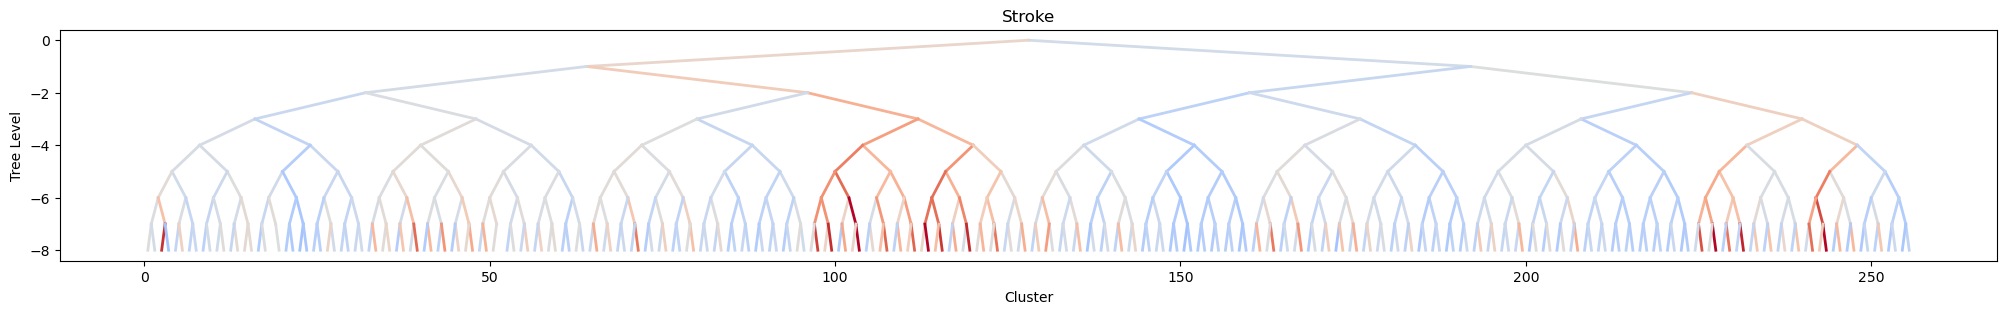

key                   []
Node Depth             0
Cluster Mean    0.081848
99% CI Low      0.078709
99% CI High     0.085067
Count              49653
Z                    0.0
P                    1.0
Name: 0, dtype: object


,key,Node Depth,Cluster Mean,99% CI Low,99% CI High,Count,Z,P,FDR Adjusted P,Measurement,Whole Population Mean
27410,"[True, True, True, False, False, False, True, ...",15,1.000000,0.588704,1.000000,10,10.579454,3.711150e-26,5.992591e-24,Stroke,0.081848
15077,"[True, True, True, True, False, False, True, T...",14,0.842105,0.531842,0.981384,19,12.066784,1.581970e-33,3.405988e-31,Stroke,0.081848
8094,"[True, True, True, True, False, False, True, T...",13,0.791667,0.514536,0.952070,24,12.657849,1.012352e-36,2.496631e-34,Stroke,0.081848
4214,"[True, True, True, False, False, False, True, ...",12,0.714286,0.484535,0.884619,35,13.610186,3.483569e-42,1.073883e-39,Stroke,0.081848
7997,"[True, True, True, False, False, False, True, ...",13,0.789474,0.472890,0.962231,19,11.232670,2.818307e-29,5.461042e-27,Stroke,0.081848
15247,"[False, True, True, True, False, True, True, T...",14,0.724138,0.470138,0.903611,29,12.587463,2.475003e-36,5.889606e-34,Stroke,0.081848
2109,"[False, True, True, True, False, True, True, T...",11,0.586777,0.465759,0.700781,121,20.099769,7.413842e-90,1.005608e-86,Stroke,0.081848
28588,"[False, True, True, True, False, True, True, T...",15,0.812500,0.465638,0.977692,16,10.645629,1.827456e-26,3.060183e-24,Stroke,0.081848
2226,"[True, True, True, False, False, False, True, ...",11,0.637931,0.460819,0.791811,58,15.384299,2.086252e-53,9.757852e-51,Stroke,0.081848
2431,"[False, True, True, True, False, False, False,...",11,0.578947,0.454185,0.696936,114,19.217882,2.622586e-82,2.736351e-79,Stroke,0.081848


In [22]:
stroke_icd_10_codes = ["I60", "I61", "I62", "I63"]
stroke_icd_9_codes = ["430", "431", "432", "433", "434", "436"]
clusters = plot_diagnosis_clusters(patient_diagnoses, encodings, stroke_icd_9_codes, stroke_icd_10_codes, "Stroke")
clusters.sort_values("99% CI Low", ascending=False)[:10]

## Plot Clusters For Patients Who Will Die In The Future
Remember, the data only includes patients who have not already died or been discharged

/opt/conda/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


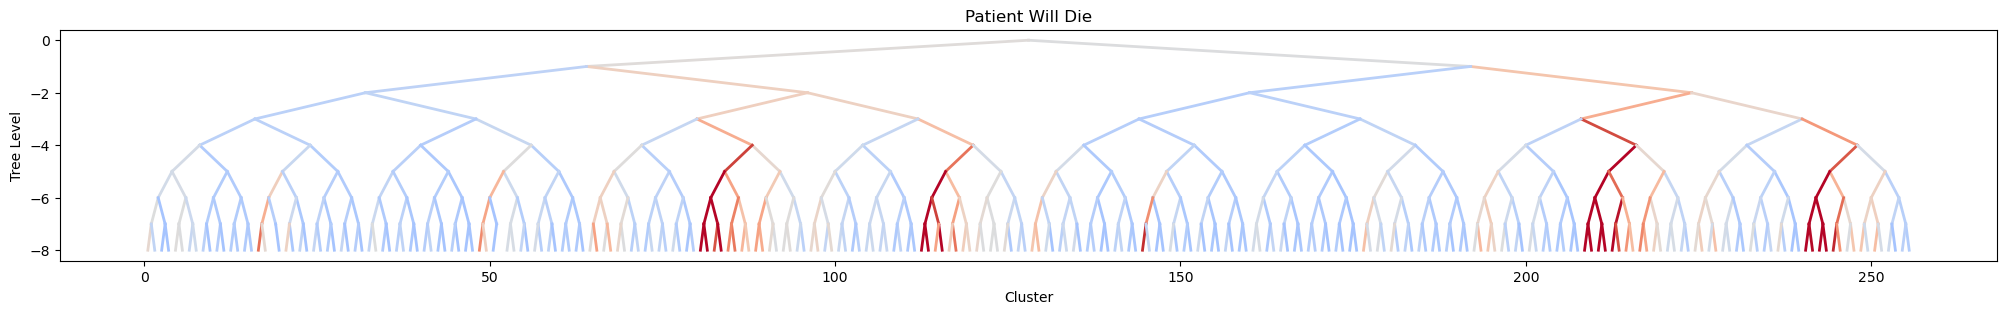

key                   []
Node Depth             0
Cluster Mean    0.067851
99% CI Low      0.064975
99% CI High      0.07081
Count              49653
Z                    0.0
P                    1.0
Name: 0, dtype: object


,key,Node Depth,Cluster Mean,99% CI Low,99% CI High,Count,Z,P,FDR Adjusted P,Measurement,Whole Population Mean
3370,"[True, True, False, True, False, False, True, ...",11,0.937500,0.741189,0.996719,32,19.480676,1.601494e-84,6.346855e-82,Patient Will Die,0.067851
5924,"[True, True, False, True, False, False, True, ...",12,0.956522,0.718556,0.999782,23,16.895338,4.869166e-64,1.273596e-61,Patient Will Die,0.067851
2142,"[True, True, False, True, False, False, True, ...",11,0.880000,0.715996,0.968137,50,22.697242,4.769938e-114,2.495283e-111,Patient Will Die,0.067851
4120,"[True, True, False, True, False, False, True, ...",12,0.885714,0.681997,0.980122,35,19.157535,8.374610e-82,3.221312e-79,Patient Will Die,0.067851
4093,"[True, True, False, True, False, False, False,...",12,0.882353,0.673841,0.979516,34,18.806847,6.636990e-79,2.411103e-76,Patient Will Die,0.067851
2030,"[True, True, False, True, False, False, False,...",11,0.807229,0.673461,0.904388,83,26.539742,3.373328e-155,3.676414e-152,Patient Will Die,0.067851
10281,"[True, True, False, True, False, False, True, ...",13,1.000000,0.665270,1.000000,13,13.340041,1.353852e-40,1.883607e-38,Patient Will Die,0.067851
2116,"[True, True, False, True, False, False, False,...",11,0.811594,0.663478,0.915035,69,24.377432,2.968127e-131,1.764440e-128,Patient Will Die,0.067851
1021,"[True, True, False, True, False, False, False,...",10,0.770642,0.651715,0.865108,109,28.842328,6.323718e-183,1.033784e-179,Patient Will Die,0.067851
4003,"[True, True, False, True, False, False, False,...",12,0.829787,0.647721,0.942507,47,20.659309,8.050765e-95,3.290291e-92,Patient Will Die,0.067851


In [24]:
encodings["label"] = y
clusters = make_binary_plot(encodings, plot_title="Patient Will Die")
clusters.sort_values("99% CI Low", ascending=False)[:10]